# Importing Packages

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import shutil

import imageio
import os
import natsort

from datetime import datetime, date, time
import scipy.io
from scipy.io import loadmat

# pd.set_option("display.precision", 15)

In [19]:
# Options are MSDR, MSRE, MSBR
# This implies that output files are named reactor_beta.out
# This imples that core_detector.mat is in directory for the reactor of interest
reactor = "MSDR"

# Parsing Scale Output for Fine Group Flux in Fuel, Graphite and Entire Cell

In [62]:
ocurrences_fine = open((reactor + "_beta.out"), 'r').read().count(
    "  Group from above   from below    to above     to below   Self-scatter    Rate          Flux")
print("There are {} fine group summary calculation results.".format(ocurrences_fine))

There are 15 fine group summary calculation results.


In [63]:
text_path = ("result_fine_" + reactor + ".txt")
if os.path.exists(text_path):
    os.remove(("result_fine_" + reactor + ".txt"))
    
outfile_msdr = open(("result_fine_" + reactor + ".txt"), "a")

with open((reactor + "_beta.out"), 'r') as f:
    textfile_temp = f.read()
    for i in range(1,ocurrences_fine+1):
        outfile_msdr.write(textfile_temp.split('  Group from above   from below    to above     to below   Self-scatter    Rate          Flux\n')[i].split(
            "  Fine group summary for mix   3, id no.   3 {graphite},\n")[0])

In [64]:
headers_msdr = ['Group No', 'In_scatter_above', 'In_scatter_below', 'Out_scatter_below', 
                'Self_scatter', 'Fission_Rate', 'Total_Flux']
df_fine = pd.read_csv(("result_fine_" + reactor + ".txt"), header=None, delimiter=r"\s+", 
                      names=headers_msdr, index_col=False)
df_fine = df_fine.apply(pd.to_numeric, args=('coerce',))

In [65]:
df_fine.head()

,Group No,In_scatter_above,In_scatter_below,Out_scatter_below,Self_scatter,Fission_Rate,Total_Flux
0,1.0,0.000000e+00,0.0,0.0,6.539000e-22,6.985520e-22,5.361730e-25
1,2.0,1.704150e-22,0.0,0.0,7.641470e-22,6.094270e-22,5.413850e-25
2,3.0,2.430830e-22,0.0,0.0,8.560000e-22,5.278800e-22,5.183100e-25
3,4.0,2.701630e-22,0.0,0.0,7.021820e-11,3.168240e-11,3.674990e-14
4,5.0,2.339690e-11,0.0,0.0,1.603430e-05,8.508160e-06,8.068890e-09


In [66]:
# ax = df_msdr.iloc[0:252, [0,6]].plot('Group No', 'Total_Flux', figsize=(12, 7), legend=None)
# plt.gca().invert_xaxis()

# Parsing Scale Output for Transport Calculation Results (Unit Cell)

We need to find the number of transport calculations that were performed.

In [67]:
ocurrences = open((reactor + "_beta.out"), 'r').read().count(" Equivalent core height is infinite.")
print("There are {} transport calculation results.".format(ocurrences))

There are 5 transport calculation results.


In [68]:
text_path = ("result_" + reactor + ".txt")
if os.path.exists(text_path):
    os.remove(("result_" + reactor + ".txt"))
    
outfile = open(("result_" + reactor + ".txt"), "a")

with open((reactor + "_beta.out"), 'r') as f:
    textfile_temp = f.read()
    for i in range(1,(ocurrences + 1)):
        outfile.write(textfile_temp.split('   No    Energy(eV)   Flux       Flux      Adj.Flux   Adj.Flux  \n')[i].split(
            " NOTE: Flux values above are per unit-lethargy.\n")[0])

### SCALE Output into Dataframe

We know define and specify our dataframe:

In [69]:
headers = ['Group No', 'Upper Energy (eV)', 'Critical Flux', 'Inf. Med. Flux.', \
           'Critical Adj. Flux', 'Inf. Med. Adj. Flux']

df = pd.read_csv(("result_" + reactor + ".txt"), header=None, delimiter=r"\s+", names=headers)

We take a peak into our resulting dataframe:

In [70]:
df.head()

,Group No,Upper Energy (eV),Critical Flux,Inf. Med. Flux.,Critical Adj. Flux,Inf. Med. Adj. Flux
0,1,20000000.0,0.000000e+00,0.000000e+00,0.000770,0.000770
1,2,17330000.0,0.000000e+00,0.000000e+00,0.001132,0.001132
2,3,15680000.0,0.000000e+00,0.000000e+00,0.001540,0.001540
3,4,14550000.0,6.374000e-12,6.374000e-12,0.002281,0.002281
4,5,13840000.0,1.031000e-06,1.031000e-06,0.001507,0.001507


We can graph the initial transport results (critical flux):

In [71]:
# ax = df.iloc[0:252, [0,2]].plot('Group No', 'Critical Flux', figsize=(15, 7), legend=None)
# plt.gca().invert_xaxis()

We can now plot every transport calculation througout time and save it for future analysis:

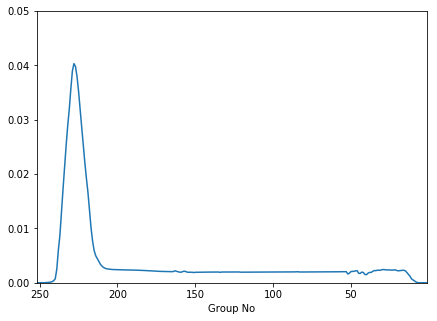

In [101]:
flux_gif = "./FluxGif/" + reactor
if os.path.exists(flux_gif):
    shutil.rmtree(flux_gif)
os.makedirs(flux_gif)

if reactor == "MSRE":
    limity = (0, 0.050)
elif reactor == "MSDR":
    limity = (0, 0.010)

ax = df.iloc[0:252, [0,2]].plot('Group No', 'Critical Flux', figsize=(7, 5), legend=None, ylim=limity)
plt.gca().invert_xaxis()
for i in range(1, ocurrences):
    df.iloc[252*i:(252*(i+1)), [0,2]].plot('Group No', 'Critical Flux', legend=None, ylim=(0, 0.010))
    plt.gca().invert_xaxis()
    plt.savefig(flux_gif + "/step" + str(i) + ".png")
    plt.close()

Having all transport calculation plots saved, we will now create an animation to observe how the flux changes with time (burnup):

In [73]:
gif_path = "./FluxGif/"
images = [] #empty list where images will be stored for animation
for file_name in natsort.natsorted(os.listdir(flux_gif)):
    if file_name.endswith('.png'):
        file_path = os.path.join(flux_gif, file_name)
        images.append(imageio.imread(file_path))

#Saving the images as an animation        
imageio.mimsave((flux_gif + '.gif'), images, fps=10)

# Importing Serpent Detector Results

In [74]:
# Importing Matlab files
detectors = scipy.io.loadmat('core_detector.mat')

# Accessing The Energy Detector DETflux_fuel
DETEnergyDetectorNP = detectors['DETflux_fuel']

# Converting Numpy Matrix to Dataframe
DETEnergyDetector = pd.DataFrame(DETEnergyDetectorNP)

C:\Users\vicen\Anaconda3\envs\data_mining\lib\site-packages\scipy\io\matlab\mio.py:208: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [75]:
# Column Names as defined by Serpent Manual
detector_columns = ["Value Index", "EBIN", "UBINS", "CBINS", "MBINS", \
                    "LBINS", "RBINS", "ZBINS", "YBINS", "XBINS", \
                    "Mean Value", "Stat. Error"]

DETEnergyDetector.columns = detector_columns # Setting the column names

In [76]:
DETEnergyDetector.head()

,Value Index,EBIN,UBINS,CBINS,MBINS,LBINS,RBINS,ZBINS,YBINS,XBINS,Mean Value,Stat. Error
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.846210e+14,0.29162
1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.673020e+14,0.31511
2,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.061520e+15,0.14455
3,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.624790e+15,0.17991
4,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.823430e+15,0.14173


In [77]:
# Getting the max flux for normalizing 
max_flux = DETEnergyDetector["Mean Value"].max()
print("The max mean flux is {}/cm^2*s".format(max_flux))

The max mean flux is 1.21472e+20/cm^2*s


In [78]:
# Normalizing by Max Energy
DETEnergyDetector["Mean_E_Norm"] = DETEnergyDetector["Mean Value"]/max_flux
DETEnergyDetector["Norm_Lethargy"] = np.log(max_flux/DETEnergyDetector["Mean Value"])

In [79]:
# DETEnergyDetector.plot('EBIN', 'Mean_E_Norm', legend=None)

# Normalizing SCALE Output

In [80]:
#Grabing only the first transport calculation
graph_scale = df.iloc[0:252, :].copy()

graph_scale_fine = df_fine.iloc[0:252, :].copy()

In [81]:
max_flux_scale = graph_scale["Critical Flux"].max()
print("The max flux is {}/cm^2*s".format(max_flux_scale))

max_flux_scale_fine = graph_scale_fine["Total_Flux"].max()
print("The max flux is {}/cm^2*s".format(max_flux_scale_fine))

The max flux is 0.04032/cm^2*s
The max flux is 0.04200159999999999/cm^2*s


In [82]:
graph_scale_fine.head()

,Group No,In_scatter_above,In_scatter_below,Out_scatter_below,Self_scatter,Fission_Rate,Total_Flux
0,1.0,0.000000e+00,0.0,0.0,6.539000e-22,6.985520e-22,5.361730e-25
1,2.0,1.704150e-22,0.0,0.0,7.641470e-22,6.094270e-22,5.413850e-25
2,3.0,2.430830e-22,0.0,0.0,8.560000e-22,5.278800e-22,5.183100e-25
3,4.0,2.701630e-22,0.0,0.0,7.021820e-11,3.168240e-11,3.674990e-14
4,5.0,2.339690e-11,0.0,0.0,1.603430e-05,8.508160e-06,8.068890e-09


In [83]:
graph_scale["E_norm"] = graph_scale["Critical Flux"]/max_flux_scale
graph_scale["Norm_Lethargy"] = np.log(max_flux_scale/graph_scale["Critical Flux"])
graph_scale = graph_scale.replace([np.inf, -np.inf], 0)

graph_scale_fine["E_norm"] = graph_scale_fine["Total_Flux"]/max_flux_scale_fine
graph_scale_fine["Norm_Lethargy"] = np.log(max_flux_scale_fine/graph_scale_fine["Total_Flux"])
graph_scale_fine = graph_scale_fine.replace([np.inf, -np.inf], 0)

In [84]:
graph_scale["E_Reverse"] = graph_scale["E_norm"].values[::-1]

graph_scale_fine["E_Reverse"] = graph_scale_fine["E_norm"].values[::-1]

In [85]:
graph_scale["L_Reverse"] = graph_scale["Norm_Lethargy"].values[::-1]

graph_scale_fine["L_Reverse"] = graph_scale_fine["Norm_Lethargy"].values[::-1]

In [86]:
# graph_scale_fine.plot('Group No', 'E_Reverse', figsize=(10, 8),  title="MSRE Flux Distribution", legend=None)

# SCALE vs SERPENT Spectra Comparison

In [87]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# DETEnergyDetector.plot('EBIN', 'Mean_E_Norm', legend=None, ax=axes[0,0])#, ylim=(0, 1.1)) , figsize=(14, 12)
# DETEnergyDetector.plot('EBIN', 'Norm_Lethargy', legend=None, ax=axes[0,1]) # figsize=(14, 12)
# graph_scale.plot('Group No', 'E_Reverse', legend=None, ax=axes[1,0])
# graph_scale.plot('Group No', 'L_Reverse', legend=None, ax=axes[1,1])

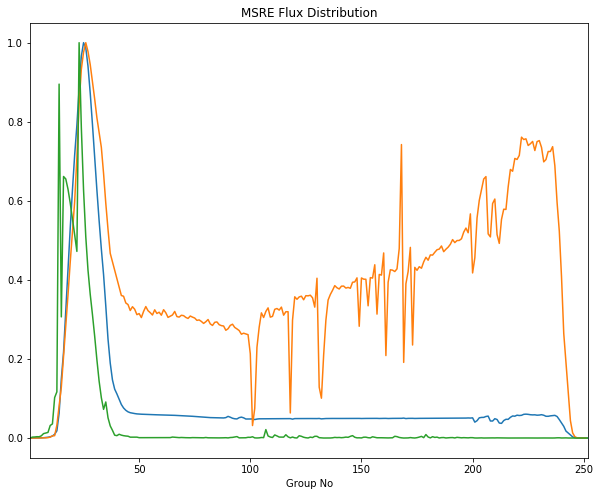

In [88]:
ax = graph_scale.plot('Group No', 'E_Reverse', figsize=(10, 8),  title="MSRE Flux Distribution", legend=None)
DETEnergyDetector.plot('EBIN', 'Mean_E_Norm', figsize=(10, 8), legend=None, ax = ax)#, ylim=(0, 1.1))
graph_scale_fine.plot('Group No', 'E_Reverse', figsize=(10, 8), legend=None, ax = ax)
plt.savefig((reactor + ".png"))

In [89]:
# ax = graph_scale.plot('Group No', 'L_Reverse', figsize=(10, 8),  title="MSRE Flux Distribution", legend=None)
# DETEnergyDetector.plot('EBIN', 'Norm_Lethargy', figsize=(10, 8), legend=None, ax = ax)#, ylim=(0, 1.1))

In [90]:
# DETEnergyDetector.plot('EBIN', 'Norm_Lethargy', figsize=(14, 12), legend=None)#, ylim=(0, 1.1))
# plt.gca().invert_yaxis()

# Getting Scale Energy Grid

In [91]:
# # Transforming Units to (MeV)
# df['Upper Energy (MeV)'] = df['Upper Energy (eV)']/(1*10**6)
# #Selecting only the first transport result
# ascending = df.iloc[0:252, [0,6]]
# #Serpent Requires values in ascending order
# ascending = ascending.sort_values(by=['Upper Energy (MeV)'], ascending=True)
# #Saving with up to 12 decimal values
# np.savetxt('SCALE252.txt', ascending['Upper Energy (MeV)'].values, fmt='%1.12f')

In [92]:
# SCALE252 = df['Upper Energy (MeV)'].values
# SCALE252 = np.sort(SCALE252)
# np.savetxt('SCALE252.txt', SCALE252, fmt='%1.12f')

In [93]:
# # This part of the code creates a series of figures overlapping each other
# ims = []
# ax = df.iloc[0:252, [0,2]].plot('Group No', 'Critical Flux', figsize=(14, 12), legend=None)
# for i in range(1,ocurrences):
#     df.iloc[252*i:(252*(i+1)), [0,2]].plot('Group No', 'Critical Flux', ax = ax, legend=None)
#     im = df.iloc[252*i:(252*(i+1)), [0,2]].plot('Group No', 'Critical Flux', ax = ax, legend=None)
#     ims.append([im])
#     plt.savefig("value" + str(i) + ".png")